# 19.03 Meeting (and Not Meeting) the Assumptions of Linear Regression
## Assignment 02

### 1. Predicting temperature

### 2. House prices

To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database. 
* Reimplement the model you built in the previous checkpoint. 
* Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.
*  be sure to close the database connection after initially pulling in your data.

In [8]:
import warnings

import numpy as np 
import pandas as pd 
import statsmodels.formula.api as smf
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import linear_model
from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL 
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats.stats import pearsonr
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf

warnings.filterwarnings(action="ignore")

kagle = dict(
    drivername = "postgresql",
    username = "dsbc_student",
    password = "7*.8G9QH21",
    host = "142.93.121.174",
    port = "5432",
    database = "houseprices"
)

In [2]:
# Load the data from the "houseprices" database
engine=create_engine(URL(**kagle), echo=True)

houses_raw=pd.read_sql_query("SELECT * FROM houseprices", con=engine)

engine.dispose()

2019-12-30 13:02:36,342 INFO sqlalchemy.engine.base.Engine select version()
2019-12-30 13:02:36,347 INFO sqlalchemy.engine.base.Engine {}
2019-12-30 13:02:36,461 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-12-30 13:02:36,463 INFO sqlalchemy.engine.base.Engine {}
2019-12-30 13:02:36,562 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-12-30 13:02:36,563 INFO sqlalchemy.engine.base.Engine {}
2019-12-30 13:02:36,614 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-12-30 13:02:36,615 INFO sqlalchemy.engine.base.Engine {}
2019-12-30 13:02:36,663 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-12-30 13:02:36,665 INFO sqlalchemy.engine.base.Engine {}
2019-12-30 13:02:36,762 INFO sqlalchemy.engine.base.Engine SELECT * FROM houseprices
2019-12-30 13:02:36,764 INFO sqlalchemy.engine.base.Engine {}


In [3]:
# Interpolate missing values 
houses_raw.groupby(["neighborhood","yearbuilt",
    'firstflrsf']).apply(lambda group: group.interpolate(limit_direction="both"))

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,...,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2010,WD,Normal,142125


In [4]:
# Having interpolated as much as possible, drop columns with null values
houses_working = houses_raw.copy()
houses_working.dropna(axis="columns",inplace=True)
houses_working.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 62 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotarea          1460 non-null int64
street           1460 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-null object
exterior2nd      1460 non-null object
exterqual        1460 non-

In [5]:
# Pull the selected continuous columns into an new dataframe to be joined with engineered columns for the mdl 
reg_model = houses_working[["overallqual","totalbsmtsf","firstflrsf","grlivarea","garagecars","garagearea",
    "kitchenabvgr","enclosedporch","saleprice"]]

# Append dummies for the mszoning categorical variable to the reg_model dataframe
reg_model = pd.concat([reg_model, 
    pd.get_dummies(houses_raw.mszoning, prefix="mszoning",  drop_first=True)], axis=1)

# Append dummies for the street categorical variable to the reg_model dataframe
reg_model = pd.concat([reg_model, 
    pd.get_dummies(houses_raw.street, prefix="street", drop_first=True)], axis=1)

# Create a list of column names for the 
dummy_column_names = list(pd.get_dummies(houses_raw.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houses_raw.street, prefix="street", drop_first=True).columns)

reg_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
overallqual      1460 non-null int64
totalbsmtsf      1460 non-null int64
firstflrsf       1460 non-null int64
grlivarea        1460 non-null int64
garagecars       1460 non-null int64
garagearea       1460 non-null int64
kitchenabvgr     1460 non-null int64
enclosedporch    1460 non-null int64
saleprice        1460 non-null int64
mszoning_FV      1460 non-null uint8
mszoning_RH      1460 non-null uint8
mszoning_RL      1460 non-null uint8
mszoning_RM      1460 non-null uint8
street_Pave      1460 non-null uint8
dtypes: int64(9), uint8(5)
memory usage: 109.9 KB


In [14]:
# Y is the target variable
Y = reg_model["saleprice"]

# X is the feature set
X = reg_model[list(reg_model.iloc[:,:8].columns) + dummy_column_names]

In [15]:
# Add a constant in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y,X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     382.6
Date:                Mon, 30 Dec 2019   Prob (F-statistic):               0.00
Time:                        13:33:38   Log-Likelihood:                -17456.
No. Observations:                1460   AIC:                         3.494e+04
Df Residuals:                    1446   BIC:                         3.501e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -8.758e+04   1.87e+04     -4.696      0.000   -1.24e+05    -5.1e+04
overallqual    2.187e+04   1120.914     19.509      0.000    1.97e+04    2.41e+04
totalbsmtsf      21.0612      4.245      4.962      0.000      12.735      29.388
firstflrsf       11.7843      5.064      2.327      0.020       1.851      21.718
grlivarea        47.5968      2.683     17.740      0.000      42.334      52.860
garagecars     1.416e+04   2973.056      4.764      0.000    8331.652       2e+04
garagearea       12.4068     10.334      1.201      0.230      -7.864      32.677
kitchenabvgr  -2.724e+04   4871.731     -5.592      0.000   -3.68e+04   -1.77e+04
enclosedporch   -39.0039     16.892     -2.309      0.021     -72.139      -5.868
mszoning_FV    2.241e+04   1.36e+04      1.649      0.099   -4245.672    4.91e+04
mszoning_RH    1.699e+04   1.57e+04      1.081      0.280   -1.38e+04    4.78e+04
mszoning_RL    2.413e+04   1.26e+04      1.909      0.057    -669.455    4.89e+04
mszoning_RM    7860.4908   1.28e+04      0.616      0.538   -1.72e+04    3.29e+04
street_Pave    4129.9653   1.61e+04      0.256      0.798   -2.75e+04    3.58e+04
==============================================================================
Omnibus:                      437.697   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47997.785
Skew:                          -0.239   Prob(JB):                         0.00
Kurtosis:                      31.085   Cond. No.                     6.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Assumption One: Linearity of the Model in its Coefficients

`LinearRegression`'s `fit()` returns a model with this assumption: $ y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \dots + \beta_nx_n $ and this construction: $$ saleprice = -0.0008758 + -2.187 overallqual + 21.0612 totalbsmtsf + 11.7843 firstflsf + 47.5968 grlivarea + 1.416 garagecars + 12.4068 garagearea + 0.0002724 kitchenabgr + -39.0039 enclosedporch + 22410 mszoning\_FV + 16990 mszoning\_RH + 24130 mszoning\_RL + 7860.4908 + 4129.9653 street\_Pave \qquad(eq.1) $$
- the coefficients in $ (eq.1) $ have been abbreviated for presentation sake.

Looking for linearity in parameters $ \beta_0 $ and $ \beta_ix_x $:  The dependent variable $ Y $ is a linear function of a random error component $ \beta_0 $ and the set of independent variables $ \sum_{i=1}^{n}\beta_ix_i $ 

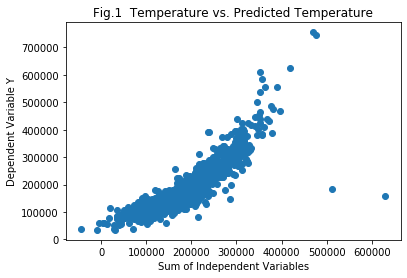

In [47]:
# Instantiate a LinearRegression model
lrm = linear_model.LinearRegression()

# fit method estimates of the coefficients using OLS
lrm.fit(X,Y)
predictions = lrm.predict(X)

# Plot X vs. Y
plt.scatter(predictions,Y)
plt.xlabel("Sum of Independent Variables")
plt.ylabel("Dependent Variable Y")
plt.title("Fig.1  Temperature vs. Predicted Temperature")
plt.show();

As demonstrated in $ Fig.1 $ the relationship between $ Y $ and $ \sum_{i=1}^{n}\beta_ix_i $ appears to be a linear one.

## Assumption Two: The Error Term Should be Zero on Average

In [26]:
errors = Y - predictions
print(f"The mean of the errors in the saleprice model is: {np.mean(errors):.14f}")

The mean of the errors in the saleprice model is: 0.00000000003126


The expected value (EV) of the error should be zero ( $ \mathbb{E} (\epsilon) = 0 $ ), for this model the EV of the error is: $ \mathbb{E} (\epsilon) = 0.00000000003126 $ which means that the model's error is effectively zero.

## Assumption Three: Homoscedasticity

Use the Bartlett and Levene tests to check the error variance is higher than for the higher values of the target variable.

In [29]:
bart_stats = bartlett(predictions,errors)
lev_stats = levene(predictions, errors)

print(f"Bartlett test statistic value is {bart_stats[0]:3g} and p-value is {bart_stats[1]:3g}")
print(f"Levene test statistic value is {lev_stats[0]:3g} and p-value is {lev_stats[1]:3g}")

Bartlett test statistic value is 524.36 and p-value is 4.76392e-116
Levene test statistic value is 517.78 and p-value is 1.1966e-105


The null hypothesis for both tests is that the errors are homoscedastic (_The conditional variance of the error term is constant in all $ x $ and over time_).  The p-values for both test are < 0.05.  These tests reject the null hypothesis which means the errors are heteroscedastic.

## Assumption Four: Low Multicollinearity

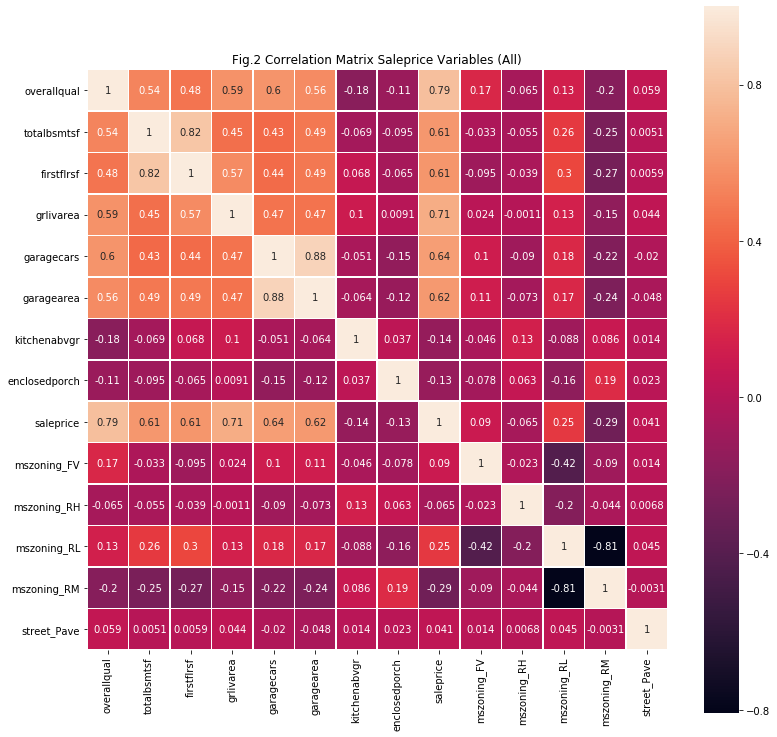

In [46]:
# Visual variable independence 
def corr_plot(corr_mat,figsize,title):
    """
        Pass in a correlation matrix and figsize (as a tuple) and plot the corresponding heatmap.
    """
    plt.figure(figsize=figsize)

    sns.heatmap(corr_mat, square=True, annot=True, linewidth=0.5)
    plt.title(title)

    # Fix display issues for this version of matplotlib
    b,t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b,t)
    # plt.yticks(rotation=360)

    plt.show();
    
corr_plot(
    corr_mat=reg_model.corr(),
    figsize=(13,13),
    title=f"Fig.2 Correlation Matrix Saleprice Variables (All)")

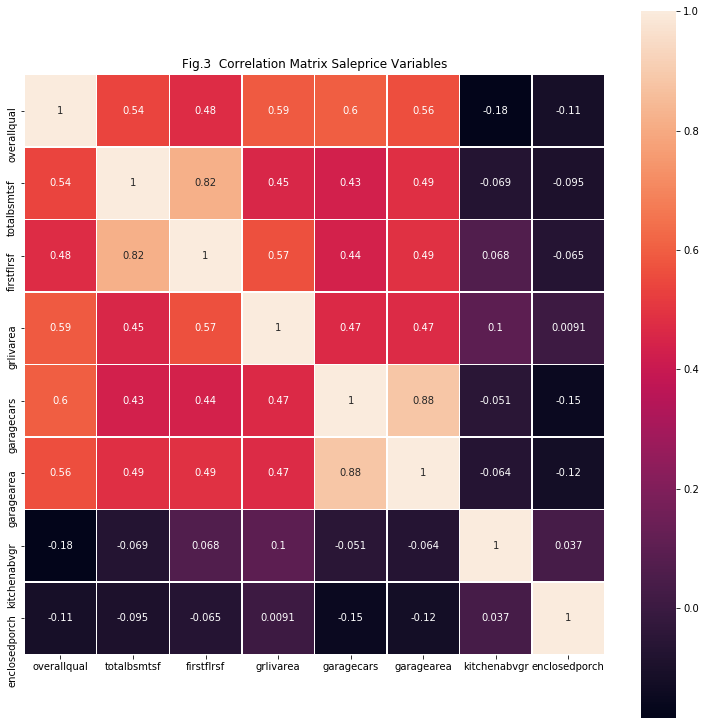

In [45]:
corr_plot(
    corr_mat=reg_model.iloc[:,:-6].corr(),
    figsize=(13,13),
    title=f"Fig.3  Correlation Matrix Saleprice Variables")

Several variables, totalbsmtdf:firstflrsf and garagecars:garagearea are tightly correlated but not perfectly correlated, one or all of these may need to be dropped.  Fig. 2 includes the categorical variables that have been one-hot encoded, Fig. 3 excludes these variables.  That said, there is not a tight correlation between the target variable and the categorical variables.

## Assumption Five: Error Terms Should be Uncorrelated with One Another

Check for randomness in the errors for the houseprice model: 

The min acf_data value is: -0.0536 and the max acf_data value is: 1.0
The range for acf_data is 1.0535964354721306


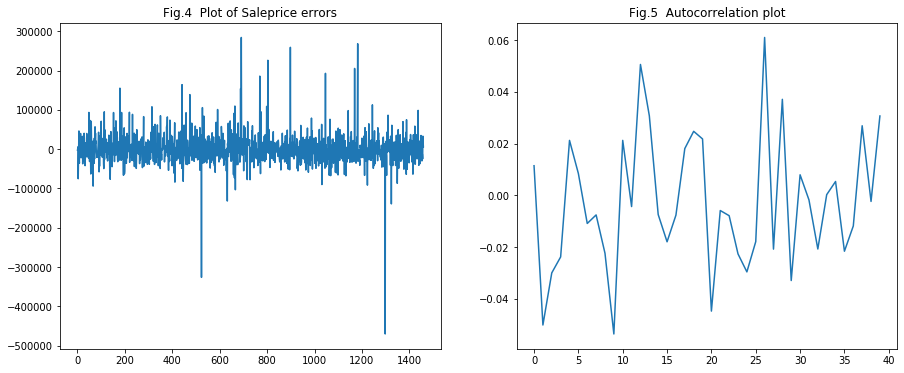

In [44]:
# Look at correlations between errors with the autocorrelation function
acf_data = acf(errors)

# Print the min and max values for the acf_data
print(f"The min acf_data value is: {acf_data.min():.4f} and the max acf_data value is: {acf_data.max()}")
print(f"The range for acf_data is {acf_data.max() - acf_data.min()}")

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(errors)
plt.title("Fig.4  Plot of Saleprice errors")

plt.subplot(1,2,2)
plt.plot(acf_data[1:])
plt.title("Fig.5  Autocorrelation plot")

plt.show();

I am not sure what the results mean

## Assumption Six: Features Shouldn't be Correlated with Errors

Jarque-Bera test statistic is 47997.7845 and the p-value is 0.0000
Normality test statistic is 437.696844 and the p-value is 0.0000


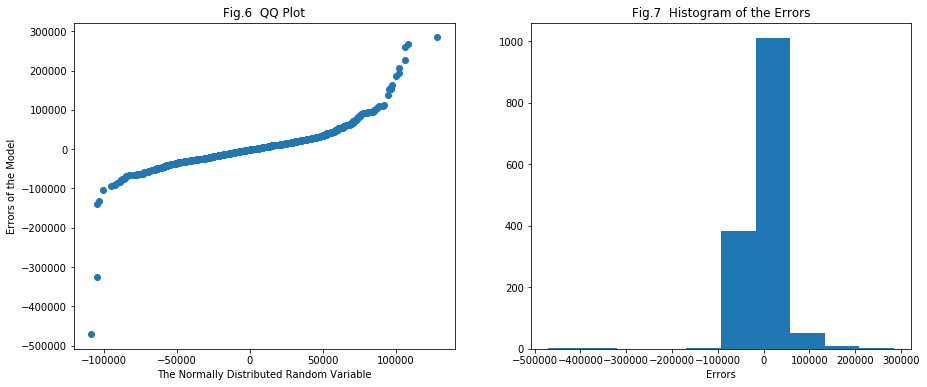

In [43]:
# Run a Jarque-Bera and Normal test and look at the p-values
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print(f"Jarque-Bera test statistic is {jb_stats[0]:.4f} and the p-value is {jb_stats[1]:.4f}")
print(f"Normality test statistic is {norm_stats[0]:4f} and the p-value is {norm_stats[1]:.4f}")

rand_sums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_sums), np.sort(errors))
plt.xlabel("The Normally Distributed Random Variable")
plt.ylabel("Errors of the Model")
plt.title("Fig.6  QQ Plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("Errors")
plt.title("Fig.7  Histogram of the Errors")

plt.show();

As you can see the p-values for both the Jarque-Bera and Normal Test are < 0.05.  A p-value > 0.05 would mean that the null hypothesis was accepted and the distribution is normal.  In this case the null hypothesis has been rejected which means the distribution is not normal.  Figs. 6 \& 7 reinforce that the errors are not distributed normally.